In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import h5py
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
ext_dir = os.path.join(data_dir,'external')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','shallow_melting','figures')

sys.path.append(src_dir)
#from tools.log_progress import log_progress

# Rignot data from Susheel

## interpolation onto ROMS grid

In [2]:
grd2_path = os.path.join(proj_dir,'data','preprocessing','processed','waom2_grd.nc')
grd2 = xr.open_dataset(grd2_path)

In [3]:
rignot_path = os.path.join(data_dir,'external','rignot','RignotEtAl2013-melt-rates.h5')
#rig = xr.open_dataset(rignot_path)
rig = {}
f = h5py.File(rignot_path)
for k, v in f.items():
    rig[k] = np.flipud(np.rot90(np.array(v)))

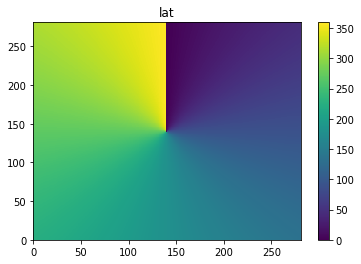

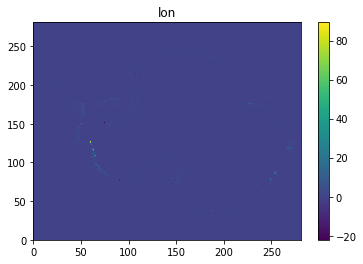

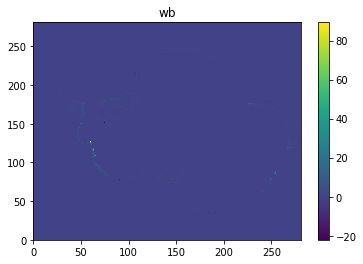

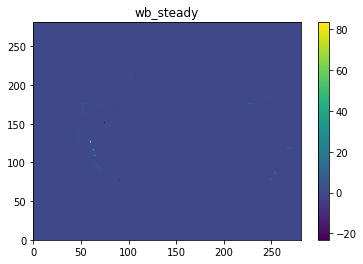

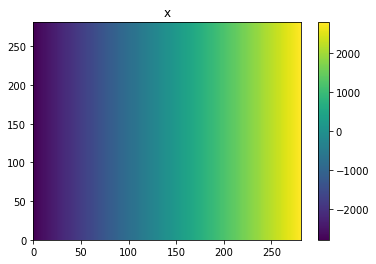

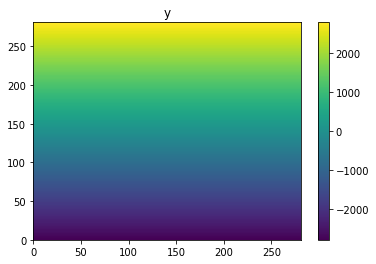

In [4]:
plt.close()
for k,v in rig.items():
    plt.pcolormesh(v[::20,::20])
    plt.colorbar()
    plt.title(k)
    plt.show()

In [ ]:
mr=2
x,y = np.meshgrid(np.arange(-3000,3300+mr/2,mr/2),np.arange(-2700,2600+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

x_rig,y_rig = np.meshgrid(np.arange(-2800,2801),np.arange(-2800,2801))

wb_rho = xr.DataArray(griddata((x_rig[::2,::2].flatten(),y_rig[::2,::2].flatten()),rig['wb'][::2,::2].flatten(),
                             (x_rho[::1,::1],y_rho[::1,::1])),dims=('eta_rho','xi_rho'))

wb_rho.values[(x_rho < -2800) | (x_rho > 2800)]=0

In [16]:
wb_rho.to_netcdf(os.path.join(int_dir,'wb_rho.nc'))

## melt rate map and depth distribiution

In [3]:
grd2_path = os.path.join(proj_dir,'data','preprocessing','processed','waom2_grd.nc')
grd2 = xr.open_dataset(grd2_path)

wb_rho_path = os.path.join(int_dir,'wb_rho.nc')
wb_rho = xr.open_dataarray(wb_rho_path)

In [139]:
from visualization.shiftedColorMap import shiftedColorMap
import matplotlib
def plot_ismr_map(m,mask,title,m_min=-1,m_max=6,out_path=False):

    m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))
    
    mask_land = (grd2.zice < 0.0)&(grd2.mask_rho==1)
    land_zice = (grd2.mask_rho==0) | (grd2.zice < 0.0)
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd2.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')),alpha=0.5)
    (m.where(mask)).plot(vmin=m_min,vmax=m_max,ax=ax,cmap=m_cmap,cbar_kwargs={'label':''})
    ax.contour(-grd2.zice.where(grd2.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5,alpha=0.5)
    ax.contour(grd2.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5,alpha=0.5)
    
    plt.title(title, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=375)
    plt.show()

<IPython.core.display.Javascript object>


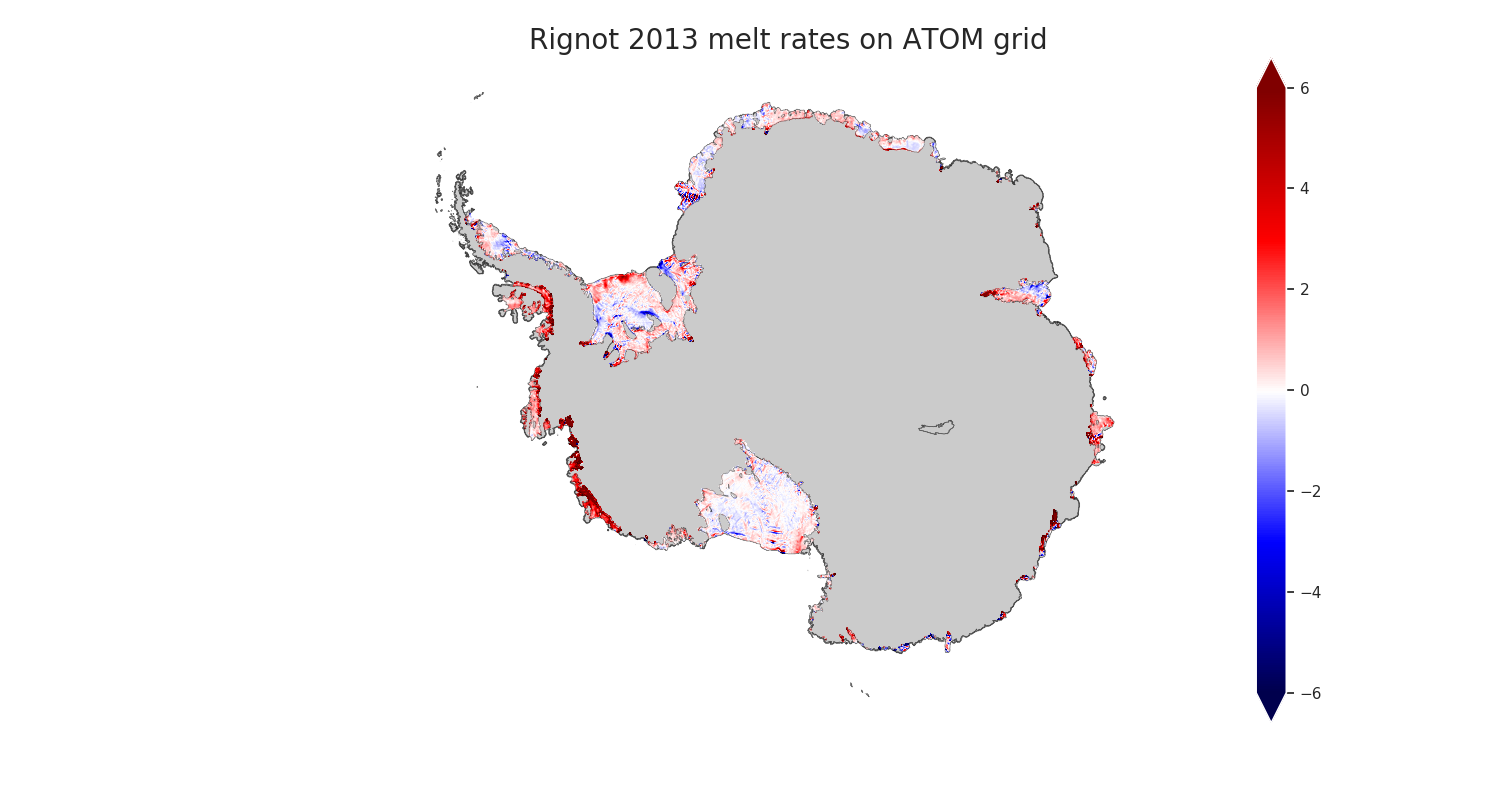

In [206]:
plot_ismr_map(wb_rho,wb_rho!=0,'Rignot 2013 melt rates on ATOM grid',m_min=-6,m_max=6,
              out_path=os.path.join(fig_dir,'Rignot_wb_on_roms_grid.png'))

In [12]:
def integrate_melt(m,dA,mask):
    rhoi = 916

    dA = dA.where(mask)
    weights = dA/dA.sum()

    ismr = (m*weights).sum()
    bmb = (m*dA*rhoi*10**-12).sum()

    print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
    print('Area average melt rate in m/yr: ',ismr.values)
    print('Basal mass loss in Gt/a: ',bmb.values)

def plot_depth_melting(m,dA,mask,bins,save=False):
    rhoi = 916

    dA = dA.where(mask)
    
    depths = (grd2.zice*-1)
    ismr2bmb = dA*rhoi*(10**-12)

    ismr = (m.where(mask).groupby_bins(depths,bins).mean()).to_series()
    A = dA.groupby_bins(depths,bins).sum().to_series()/10**9
    bmb =  ((m.where(mask)*ismr2bmb).groupby_bins(depths,bins).sum()).to_series()
    
    print('400 m fraction: ',bmb.loc[slice(0,400)].sum()/bmb.sum(),bmb.loc[slice(0,400)].sum())
    print('200 m fraction: ',bmb.loc[slice(0,200)].sum()/bmb.sum(),bmb.loc[slice(0,200)].sum())
    print('200-400 m fraction: ',bmb.loc[slice(201,400)].sum()/bmb.sum(),bmb.loc[slice(201,400)].sum())

    plt.rcParams.update({'font.size': 18})
    plt.close()
    fig,axes = plt.subplots(3,figsize=(12,12))
    ax1,ax2,ax3 = axes.flatten()
    ismr.plot.bar(ax=ax1,color='k')
    bmb.plot.bar(ax=ax2,color='k')
    A.plot.bar(ax=ax3,color='k')
    ax1.set_ylabel('Melt rate (m/yr)')
    ax2.set_ylabel('Basal mass loss (Gt/yr)')
    ax3.set_ylabel('Area (10$^3$ km$^2$)')
    for ax in [ax1,ax2]:
        #ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.xaxis.grid(True)
    ax3.xaxis.grid(True)
    depth_str = list()
    #for i in bins:
    #    depth_str.append(f'{i}-{i+100}')
    #ax3.set_xticklabels(depth_str)
    ax3.set_xlabel('Depth ranges (m)')
    ax1.set_ylim(0,5.2)
    ax2.set_ylim(0,300)
    ax3.set_ylim(0,440)
    plt.savefig(os.path.join(fig_dir,'ATOM_depth_bins_data.png'),transparent=True,bbox_inches = "tight")
    plt.show()
    
    return ismr,A,bmb

In [6]:
dA = (grd2.pm*grd2.pn)**-1
integrate_melt(wb_rho,dA,wb_rho==0)

Area of all ice shelves in 10^3 km^2:  31121.036733369918
Area average melt rate in m/yr:  0.0
Basal mass loss in Gt/a:  0.0


400 m fraction:  0.47797224048862036 428.1497822124369
200 m fraction:  0.10332425658323513 92.55403181605335
200-400 m fraction:  0.3746479839053852 335.5957503963835


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

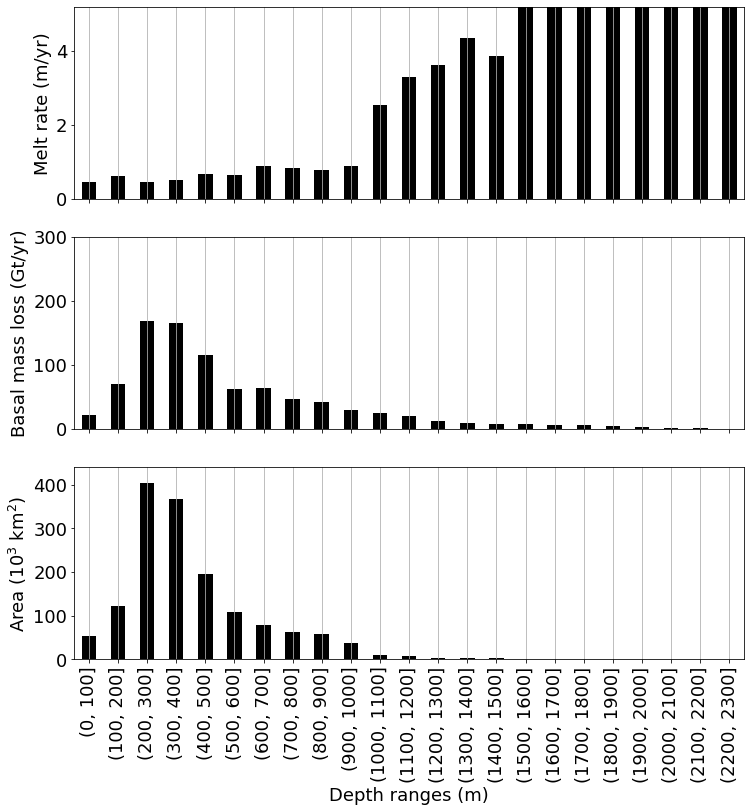

In [14]:
ismr_R,A_R,bmb_R = plot_depth_melting(wb_rho,dA,wb_rho!=0,np.arange(0,2400,100),save=False)

### comparison against ATOM

In [8]:
m_path = os.path.join(int_dir,'m2.nc')
#m_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_m_avg.nc')
ismr = xr.open_dataarray(m_path).squeeze()

mask_vostock = (grd2.lat_rho<-75) & (grd2.lat_rho>-80) & (grd2.lon_rho>95) & (grd2.lon_rho<115)
mask_ice = (grd2.mask_rho ==1) & (grd2.zice < 0) & (mask_vostock == 0)

s2a=365.25*24*3600

In [13]:
integrate_melt(ismr*s2a,dA,mask_ice)

Area of all ice shelves in 10^3 km^2:  1617.6153939146484
Area average melt rate in m/yr:  0.8146126215994695
Basal mass loss in Gt/a:  1207.0406037672076


400 m fraction:  0.788797107308594 952.1101366556136
200 m fraction:  0.3322110430090121 400.9922179317408
200-400 m fraction:  0.45658606429958176 551.1179187238727


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

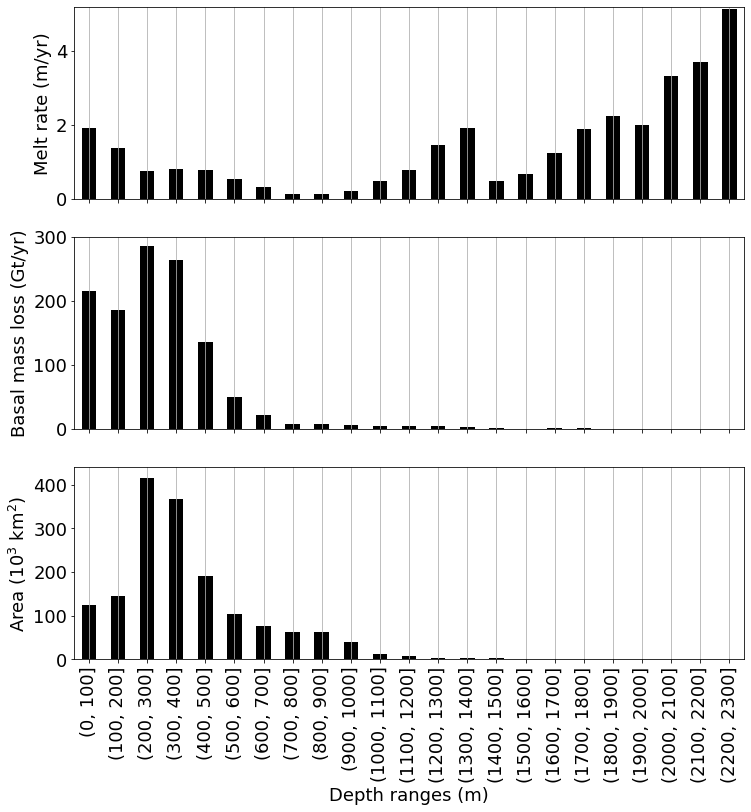

In [15]:
ismr_A,A_A,bmb_A = plot_depth_melting(ismr*s2a,dA,mask_ice,np.arange(0,2400,100),save=False)

In [19]:
df = pd.DataFrame({'ismrW':ismr_A,'ismrR':ismr_R,'bmbW':bmb_A,'bmbR':bmb_R,'AW':A_A,'AR':A_R})
df.to_csv(os.path.join(int_dir,'depthMeltingRignotWaom.csv'))

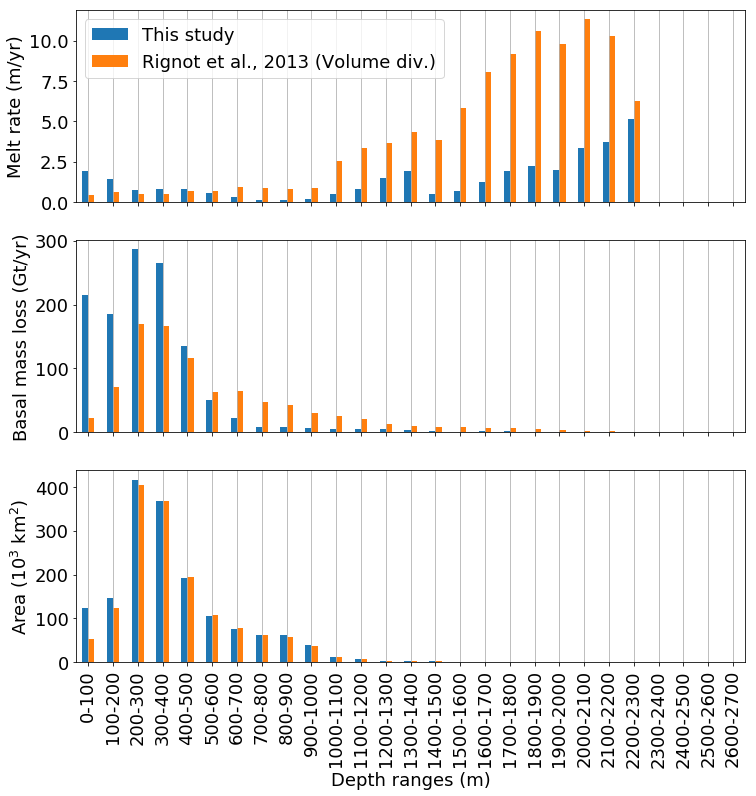

In [57]:
%matplotlib inline
#sns.set(style='darkgrid',font_scale=2)
plt.rcParams.update({'font.size': 18})
plt.close()
fig,axes = plt.subplots(3,figsize=(12,12))
ax1,ax2,ax3 = axes.flatten()
pd.concat({'Rignot':ismr_R,'ATOM':ismr_A},axis=1).plot.bar(ax=ax1,legend=False)
pd.concat({'Rignot':bmb_R,'ATOM':bmb_A},axis=1).plot.bar(ax=ax2,legend=False)
pd.concat({'Rignot':A_R,'ATOM':A_A},axis=1).plot.bar(ax=ax3,legend=False)
ax1.set_ylabel('Melt rate (m/yr)')
ax2.set_ylabel('Basal mass loss (Gt/yr)')
ax3.set_ylabel('Area (10$^3$ km$^2$)')
for ax in [ax1,ax2]:
    #ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.xaxis.grid(True)
ax3.xaxis.grid(True)
depth_str = list()
for i in np.arange(0,2800,100):
    depth_str.append(f'{i}-{i+100}')
ax3.set_xticklabels(depth_str)
ax3.set_xlabel('Depth ranges (m)')
ax1.legend(('This study','Rignot et al., 2013 (Volume div.)'))
#ax1.set_ylim(0,5.2)
#ax2.set_ylim(0,300)
#ax3.set_ylim(0,440)
plt.savefig(os.path.join(fig_dir,'Rignot_depth_bins_comparison.png'),transparent=True,bbox_inches = "tight")
plt.show()

In [107]:
shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 
shelves2 = np.load(shelves_masks_path,allow_pickle=True).item()
mask_shelves = np.zeros_like(grd2.mask_rho)
for key,values in log_progress(shelves2.items(),every=2):
        mask_shelves[values['mask']==1]=1

In [241]:
sector_mask = os.path.join(int_dir,'sector2+.npy')
sector2 = np.load(sector_mask,allow_pickle=True).item()

In [243]:
ismr.values[(sector2['Amundsen Sea'] == 1)|(sector2['Bellingshausen Sea'] == 1)] *=2 

In [312]:
from scipy.ndimage.morphology import binary_dilation as bd

mask_oo = (grd2.mask_rho == 1) & (grd2.zice==0)
mask_fz = bd(mask_oo,iterations=1)

mask_comp = (mask_ice!=0) & (wb_rho!=0)

## ice shelf average quantities compared to ATOM

In [19]:
dA = (grd2.pm*grd2.pn)**-1

for k,v in log_progress(shelves2.items(),every = 2):
    rhoi = 916
    mask =( v['mask'] == 1) & (wb_rho != 0)
    mask_shallow = (mask == 1) & (grd2.zice > -400)
    mask_very_shallow = (mask_shallow == 1) & (grd2.zice > -200)
    
    weights = dA.where(mask)/dA.where(mask).sum()
    
    shelves2[k]['A_r'] = dA.where(mask).sum()/10**9
    shelves2[k]['ismr_r'] = (wb_rho*weights).sum()
    shelves2[k]['bmb_r'] = (wb_rho.where(mask)*dA*rhoi*10**-12).sum()
    
    shelves2[k]['A_shallow_r'] = dA.where(mask_shallow).sum()/10**9
    shelves2[k]['bmb_shallow_r'] = (wb_rho.where(mask_shallow)*dA*rhoi*10**-12).sum()
    shelves2[k]['frac_bmb_shallow_r'] = (wb_rho.where(mask_shallow)*dA).sum()/(wb_rho.where(mask)*dA).sum()

In [20]:
m_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_m_avg.nc')
ismr = xr.open_dataarray(m_path)

s2a = 3600*24*365.25
for k,v in log_progress(shelves2.items(),every = 2):
    rhoi = 916
    mask = (v['mask'] == 1) & (wb_rho != 0)
    mask_shallow = (mask == 1) & (grd2.zice > -400)
    weights = dA.where(mask)/dA.where(mask).sum()
    
    shelves2[k]['rm'] = mask
    shelves2[k]['rm_shallow'] = mask
    
    shelves2[k]['A_rm'] = dA.where(mask).sum()/10**9
    shelves2[k]['ismr_rm'] = (ismr*weights*s2a).sum()
    shelves2[k]['bmb_rm'] = (ismr.where(mask)*s2a*dA*rhoi*10**-12).sum()
    
    shelves2[k]['A_shallow_rm'] = dA.where(mask_shallow).sum()/10**9
    shelves2[k]['bmb_shallow_rm'] = (ismr.where(mask_shallow)*s2a*dA*rhoi*10**-12).sum()
    shelves2[k]['frac_bmb_shallow_rm'] = (ismr.where(mask_shallow)*dA).sum()/(ismr.where(mask)*dA).sum()

In [35]:
from scipy.ndimage.morphology import binary_dilation as bd

mask_oo = (grd2.mask_rho == 1) & (grd2.zice==0)
mask_bd = bd(mask_oo,iterations=1)

for k,v in log_progress(shelves2.items(),every = 2):
    rhoi = 916
    mask = (v['mask'] == 1) & (mask_bd == 0)
    mask_shallow = (mask == 1) & (grd2.zice > -400)
    weights = dA.where(mask)/dA.where(mask).sum()
    
    shelves2[k]['fm'] = mask
    shelves2[k]['fm_shallow'] = mask
    
    shelves2[k]['A_fm'] = dA.where(mask).sum()/10**9
    shelves2[k]['ismr_fm'] = (ismr*weights*s2a).sum()
    shelves2[k]['bmb_fm'] = (ismr.where(mask)*s2a*dA*rhoi*10**-12).sum()
    
    shelves2[k]['A_shallow_fm'] = dA.where(mask_shallow).sum()/10**9
    shelves2[k]['bmb_shallow_fm'] = (ismr.where(mask_shallow)*s2a*dA*rhoi*10**-12).sum()
    shelves2[k]['frac_bmb_shallow_fm'] = (ismr.where(mask_shallow)*dA).sum()/(ismr.where(mask)*dA).sum()

In [66]:
import pandas as pd
import seaborn as sns

avg = pd.DataFrame.from_dict(shelves2).T[['A_r','ismr_r','bmb_r','frac_bmb_shallow_r','A_shallow_r',
                                          'A_rm','ismr_rm','bmb_rm','frac_bmb_shallow_rm','A_shallow_rm',
                                         'A_fm','ismr_fm','bmb_fm','frac_bmb_shallow_fm','A_shallow_fm']].dropna(axis=0,how='any').astype(float)

#avg.to_feather(os.path.join(int_dir,'df_rignot'))

<IPython.core.display.Javascript object>


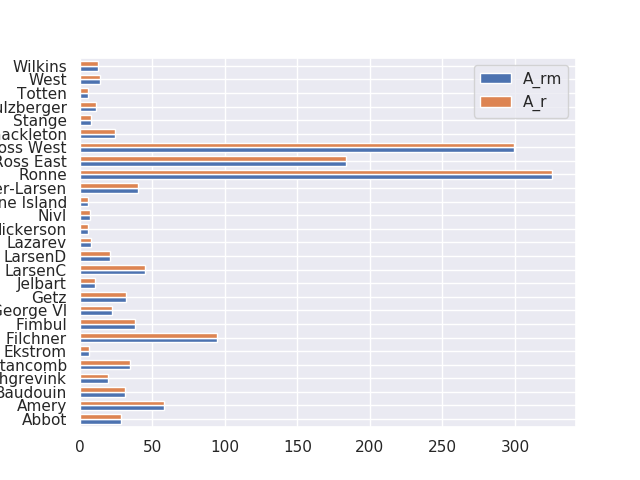

<IPython.core.display.Javascript object>


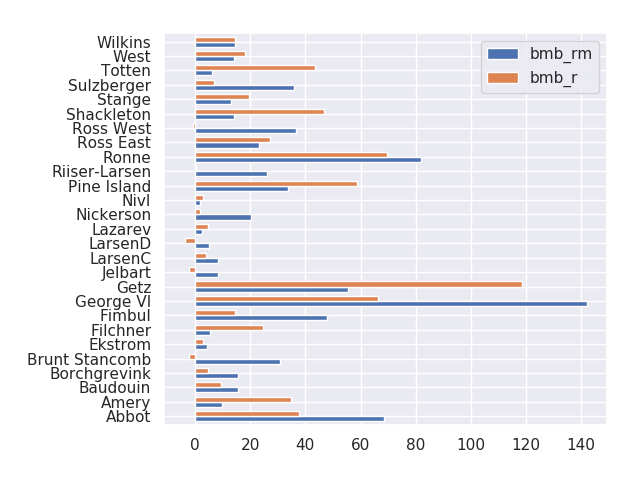

In [146]:
for key in ['A','bmb']:
    avg[avg['A_r']>5][[key+'_rm',key+'_r']].plot(kind='barh',width=0.7)
plt.tight_layout()
#plt.xlim([-0.5,2])

In [304]:
avg['bmb_r'][['Fimbul','Jelbart']].sum()

12.11096689851437

In [309]:
avg['bmb_r']['George VI']

66.17758583565315

<IPython.core.display.Javascript object>


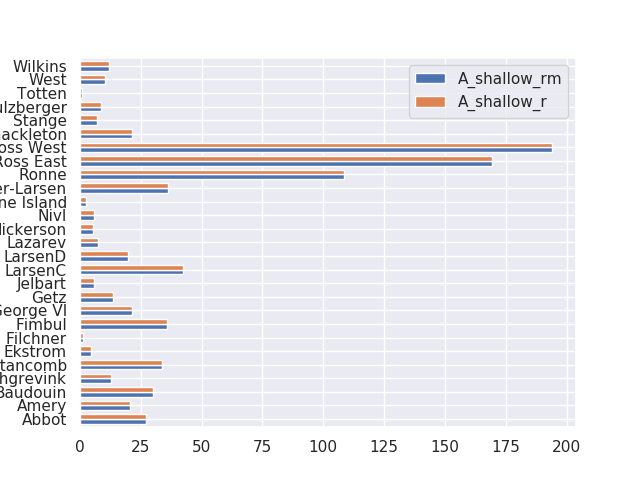

<IPython.core.display.Javascript object>


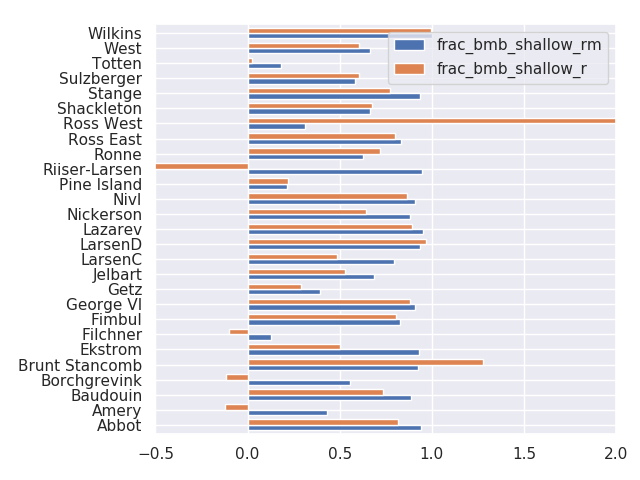

(-0.5, 2)

In [73]:
import seaborn as sns
sns.set();
for key in ['A','frac_bmb']:
    avg[avg['A_r']>5][[key+'_shallow_rm',key+'_shallow_r']].plot(kind='barh',width=0.7)
plt.tight_layout()
plt.xlim([-0.5,2])

<IPython.core.display.Javascript object>


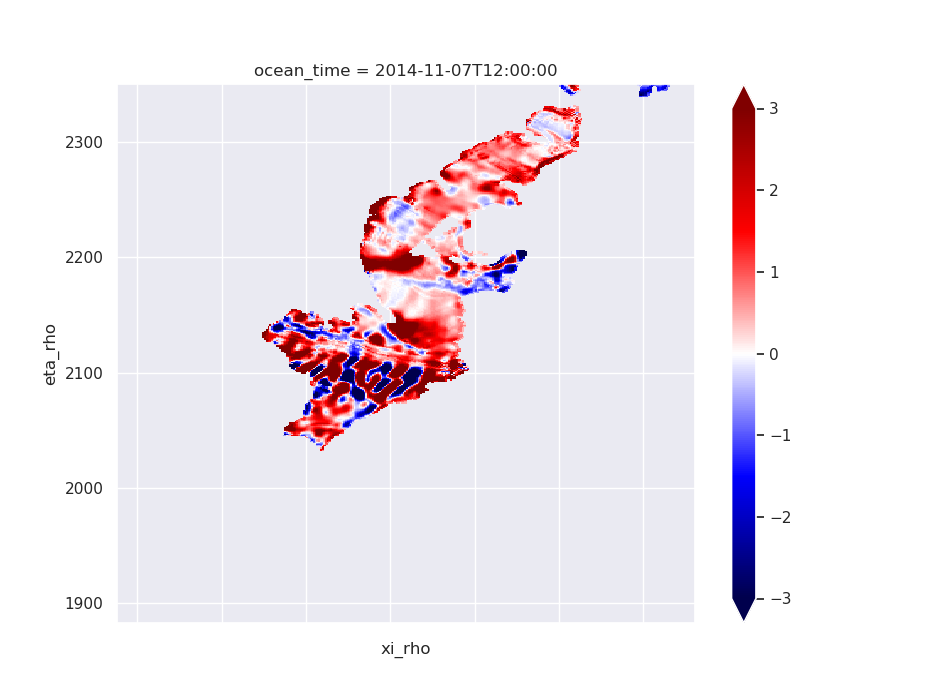

In [47]:
(ismr*s2a-wb_rho).where(wb_rho!=0).plot(size=7,vmax=3,vmin=-3,cmap='seismic')

In [ ]:
avg[avg['A_r']>10][['A_shallow_r','A_shallow_rm']].plot(kind='barh')

In [ ]:
mask = shelves2['Ross West']['mask']
plt.close()
(ismr.where(mask)*s2a-wb_rho).plot()
plt.show()

In [ ]:
plt.close()
fig,ax1 = plt.subplots(figsize=(15,15))
mlc.iloc[3:39:3].plot(kind='barh',y='This study',ax=ax1,color='silver',width=0.9,fontsize=24)
data.plot(kind='barh',xerr=errors,ax=ax1,width=0.7,fontsize=24,alpha=0.7)
ax1.legend(['This study','Liu 2015','Depoorter 2013','Rignot 2013'],markerscale=1,fontsize=24,loc=4)
#ax1.set_title('Ice shelf basal mass loss compared to observations',fontsize=24)
ax1.set_xlabel('mass loss in Gt/yr',fontsize=24)
ax1.grid(axis='x')
#ax1.set_xlim(0,350)

plt.savefig(out_path,format='png',bbox_to_anchor=True,bbox_inches='tight')
plt.show()

# Digitize Rignot
## Georef

<IPython.core.display.Javascript object>


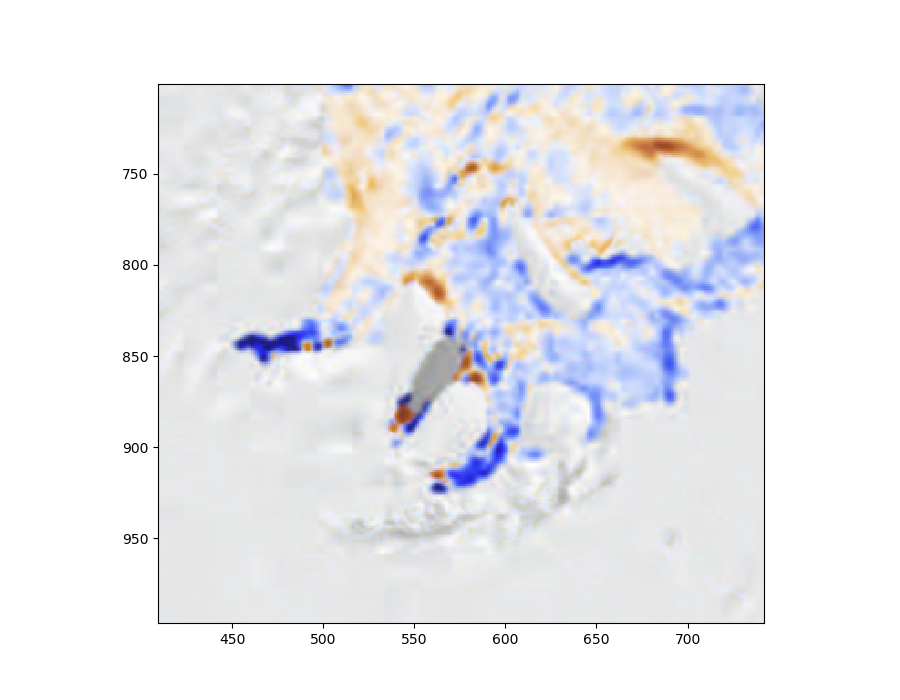

In [64]:
import cv2
%matplotlib notebook
plt.close()
plt.figure(figsize=(9,7))
impath = os.path.join(data_dir,'external','rignot','266.png')
nemo_img = cv2.imread(impath)[::,::,:]
plt.imshow(nemo_img)
plt.show()

In [24]:
points_R = np.array([[280,1074],[2173,862],[1097,120],[1377,1827]])

In [41]:
grd_path = os.path.join(int_dir,'grd2_dV.nc')
grd2 = xr.open_dataset(grd_path)

<IPython.core.display.Javascript object>


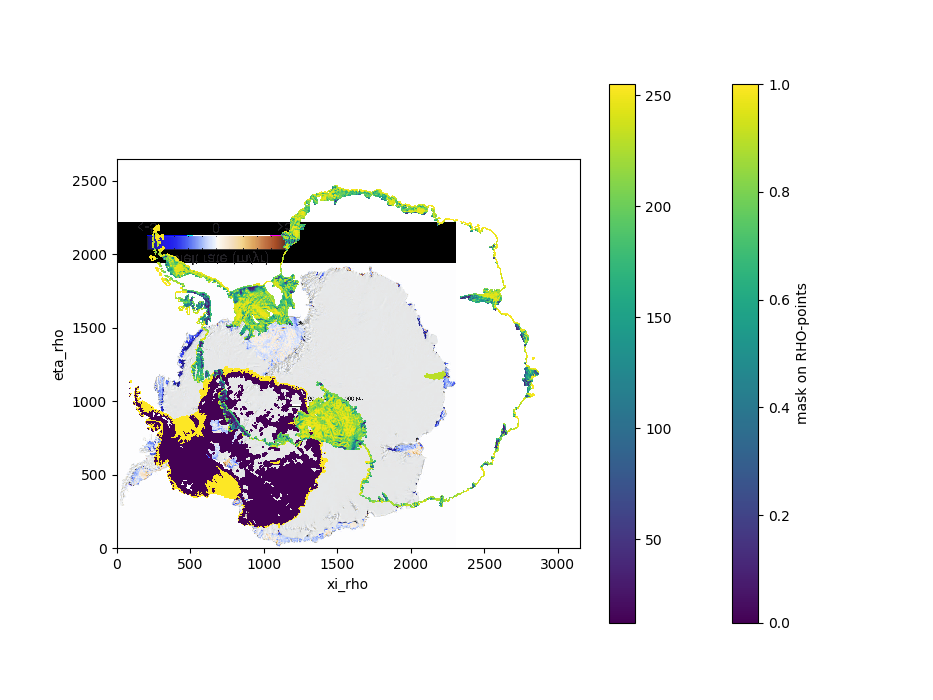

In [18]:
grd.mask_rho.where(grd.zice<0)[::2,::2].plot(size=7)

In [25]:
points_A = np.array([[272,624],[1361,743],[743,1171],[904,188]])

In [26]:
points_R[:,1]=nemo_img.shape[0]-points_R[:,1]
points_A *=2

In [33]:
x_fac = (points_A[1,0] - points_A[0,0])/(points_R[1,0] - points_R[0,0])
y_fac = (points_A[2,1] - points_A[3,1])/(points_R[2,1] - points_R[3,1])
fac = np.mean((x_fac,y_fac))
x_shift = np.mean(points_A[:,0]-points_R[:,0]*fac)
y_shift = np.mean(points_A[:,1]-points_R[:,1]*fac)

In [42]:
eta_nemo_img = np.arange(nemo_img.shape[0])*fac+y_shift
xi_nemo_img = np.arange(nemo_img.shape[1])*fac+x_shift
xi_nemo_img_2d,eta_nemo_img_2d, = np.meshgrid(xi_nemo_img,eta_nemo_img)
points = (eta_nemo_img_2d.flatten(),xi_nemo_img_2d.flatten())
data = np.flipud(nemo_img)
data = np.reshape(data,(data.shape[0]*data.shape[1],3))
xi_2d = np.broadcast_to(grd2.xi_rho.values,grd2.mask_rho.shape)
eta_2d = np.repeat(grd2.eta_rho.values[:,np.newaxis], grd2.xi_rho.size, axis=1)
tar = (eta_2d,xi_2d)
nemo_img_rho = griddata(points,data,tar)
mask_ice = (grd2.mask_rho == 1) & (grd2.zice < 0)
nemo_da = xr.DataArray(nemo_img_rho,dims=('eta_rho','xi_rho','rgb')).where(mask_ice)

<IPython.core.display.Javascript object>


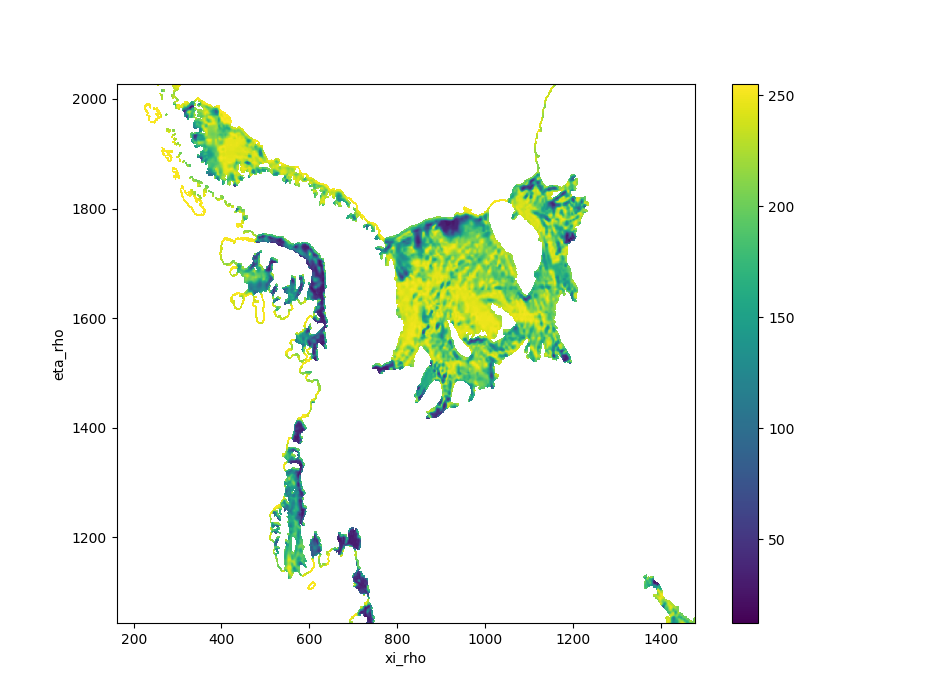

In [48]:
nemo_da[:,:,0].plot(size=7)

### Replicate colorbar

<IPython.core.display.Javascript object>


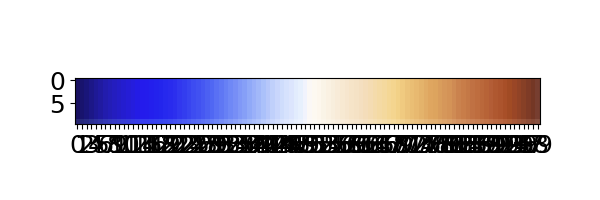

In [113]:
plt.close()
plt.figure(figsize=(6,2))
impath = os.path.join(data_dir,'external','rignot','g3841.png')
c_img = cv2.imread(impath)[::,::,:]
plt.imshow(c_img)
#plt.grid()
plt.xticks(np.arange(100))
plt.show()

In [110]:
ct = {'red':[],'green':[],'blue':[]}
for i,step in enumerate(np.linspace(0,1,100)):
    c = c_img[5,i,:]/255
    for j,rgb in enumerate(['red','green','blue']):
        ct[rgb].append([step,c[j],c[j]])

<IPython.core.display.Javascript object>


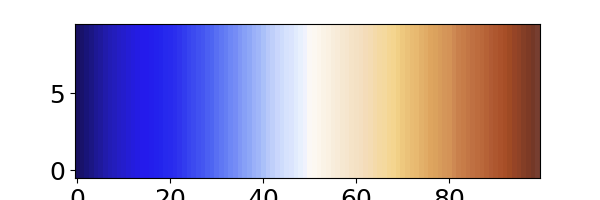

In [112]:
cmn = LinearSegmentedColormap('colormap_nemo', segmentdata=ct, N=256)
a=np.outer(np.arange(0,1,0.01),np.ones(10)).T
plt.figure(figsize=(6,2))
plt.imshow(a,aspect='auto',cmap=cmn,origin="lower")

In [51]:
def unmap_nearest(img, rgb):
    """ img is an image of shape [n, m, 3], and rgb is a colormap of shape [k, 3]. """
    d = np.sum(np.abs(img[np.newaxis, ...] - rgb[:, np.newaxis, np.newaxis, :]), axis=-1)    
    i = np.argmin(d, axis=0)
    return i / (rgb.shape[0] - 1)

In [114]:
cmap = cmn
rgb = cmap(np.linspace(0, 1, cmap.N))[:, :3]
recon = unmap_nearest(nemo_da.values[::2,::2]/255,rgb)
recon_da = (xr.DataArray(recon, dims=('eta_rho','xi_rho')).where(mask_ice[::2,::2])-0.5)*10

## masking and depth melting 

In [53]:
shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 
shelves2 = np.load(shelves_masks_path,allow_pickle=True).item()

shelf_mask = np.zeros_like(grd2.mask_rho)[::2,::2]
for key,values in log_progress(shelves2.items(),every=2):
        shelf_mask[values['mask'][::2,::2]==1]=1
#front_map = xr.DataArray(front_map,dims=('eta_rho','xi_rho')).where(front_map==1)

<IPython.core.display.Javascript object>


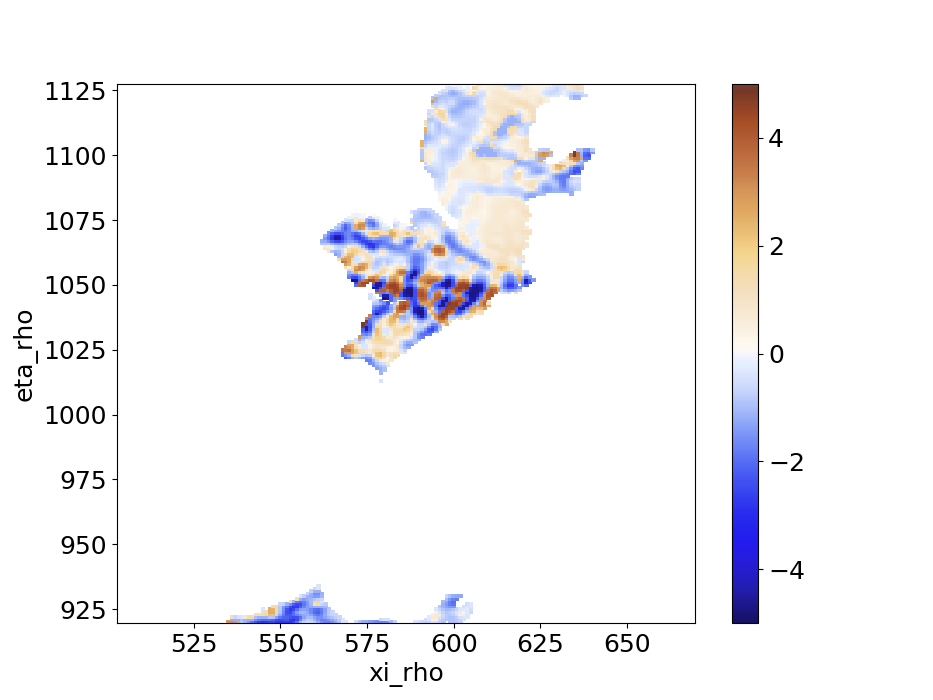

In [115]:
plt.close()
recon_da.where(shelf_mask).plot(cmap = cmn,size=7)
plt.savefig(os.path.join(fig_dir,'Rignot_digi2.png'),transparent=True,dpi=300,bbox_inches = "tight")
plt.show()

In [142]:
recon_ad = recon_da.copy()
#recon_ad.values[recon_da==-5]=-100

rhoi = 916

dA = (((grd2.pm*grd2.pn)[::2,::2]**-1)*4).where(shelf_mask)
weights = dA/dA.sum()

ismr = (recon_ad*weights).sum()
bmb = (recon_ad*dA*rhoi*10**-12).sum()

print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
print('Area average melt rate in m/yr: ',-ismr.values)
print('Basal mass loss in Gt/a: ',-bmb.values)

Area of all ice shelves in 10^3 km^2:  1522.9990420659
Area average melt rate in m/yr:  0.47349599427080136
Basal mass loss in Gt/a:  660.5586942579821


In [143]:
bins = np.arange(0,2800,100)
depths = grd2.zice[::2,::2]*-1
ismr2bmb = dA*rhoi*(10**-12)

ismr = (-recon_ad.where(shelf_mask).groupby_bins(depths,bins).mean()).to_series()
A = dA.groupby_bins(depths,bins).sum().to_series()/10**9
bmb =  ((-recon_ad.where(shelf_mask)*ismr2bmb).groupby_bins(depths,bins).sum()).to_series()

<IPython.core.display.Javascript object>


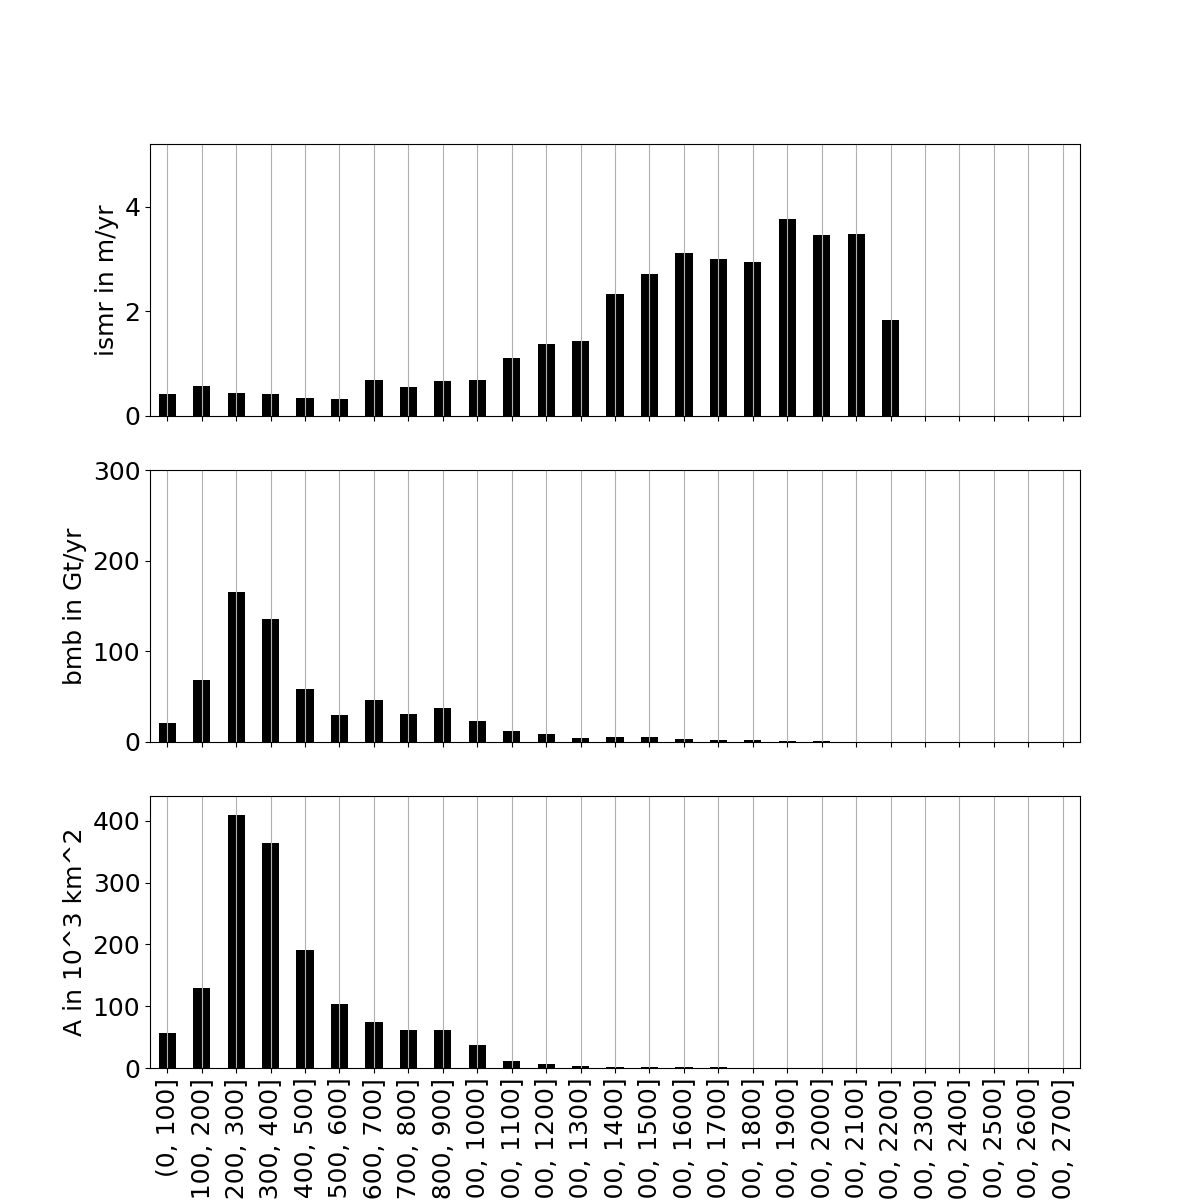

In [144]:
plt.rcParams.update({'font.size': 18})
plt.close()
fig,axes = plt.subplots(3,figsize=(12,12))
ax1,ax2,ax3 = axes.flatten()
ismr.plot.bar(ax=ax1,color='k')
bmb.plot.bar(ax=ax2,color='k')
A.plot.bar(ax=ax3,color='k')
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('bmb in Gt/yr')
ax3.set_ylabel('A in 10^3 km^2')
for ax in [ax1,ax2]:
    #ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.xaxis.grid(True)
ax3.xaxis.grid(True)
ax3.set_xlabel('depth bins in m')
ax1.set_ylim(0,5.2)
ax2.set_ylim(0,300)
ax3.set_ylim(0,440)
plt.savefig(os.path.join(fig_dir,'Rignot_depth_bins2.png'),transparent=True,bbox_inches = "tight")
plt.show()

In [145]:
bmb.loc[slice(0,200)].sum()/bmb.sum()

0.1359493062101402

array([ -69.30772005,  -68.15657863,  -67.0054372 , ..., 2477.0171156 ,
       2478.16825702, 2479.31939845])

<IPython.core.display.Javascript object>


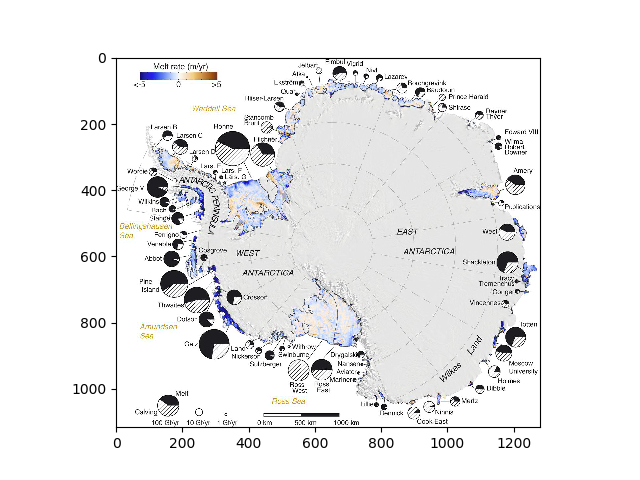

In [2]:
import cv2
%matplotlib notebook
plt.close()
impath = os.path.join(data_dir,'external','rignot','meltRates.jpg')
nemo_img = cv2.imread(impath)[::,::,:]
plt.imshow(nemo_img)
plt.show()

In [4]:
from scipy.interpolate import griddata
lat_lon = np.array([[-70,60],[-70,140],[-70,80],[-65,-80],[-75,-140]])
Rxy = np.array([[1083,320],[972,952],[1143,483],[34,460],[412,855]])
Rxy[:,1]=nemo_img.shape[0]-Rxy[:,1]

grd_path = os.path.join(proj_dir,'data','preprocessing','processed','waom2_grd.nc')
grd2= xr.open_dataset(grd_path)

lat_rho = grd2.lat_rho.values
lon_rho = grd2.lon_rho.values
xi_2d = np.broadcast_to(grd2.xi_rho.values,grd2.mask_rho.shape)
eta_2d = np.repeat(grd2.eta_rho.values[:,np.newaxis], grd2.xi_rho.size, axis=1)

tar = lat_lon
xi = griddata((lat_rho.flatten()[::10],lon_rho.flatten()[::10]),xi_2d.flatten()[::10],tar)
eta = griddata((lat_rho.flatten()[::10],lon_rho.flatten()[::10]),eta_2d.flatten()[::10],tar)

In [5]:
x_ratio = 500/227+0.02
y_ratio = x_ratio
print(xi-Rxy[:,0]*x_ratio)
print(eta - Rxy[:,1]*y_ratio)
x_shift = np.mean(xi-Rxy[:,0]*x_ratio)
y_shift = np.mean(eta - Rxy[:,1]*y_ratio)
eta_nemo_img = np.arange(nemo_img.shape[0])*y_ratio+y_shift
xi_nemo_img = np.arange(nemo_img.shape[1])*x_ratio+x_shift
xi_nemo_img_2d,eta_nemo_img_2d, = np.meshgrid(xi_nemo_img,eta_nemo_img)
points = (eta_nemo_img_2d.flatten(),xi_nemo_img_2d.flatten())
data = np.flipud(nemo_img)
data = np.reshape(data,(data.shape[0]*data.shape[1],3))
tar = (eta_2d,xi_2d)
nemo_img_rho = griddata(points,data,tar)
mask_ice = (grd2.mask_rho == 1) & (grd2.zice < 0)
nemo_da = xr.DataArray(nemo_img_rho,dims=('eta_rho','xi_rho','rgb')).where(mask_ice)

[42.62145695 44.3919148  39.5963378  65.63270509 57.0725986 ]
[128.89936895 144.44874743 133.10185546 130.9500947  141.70197911]


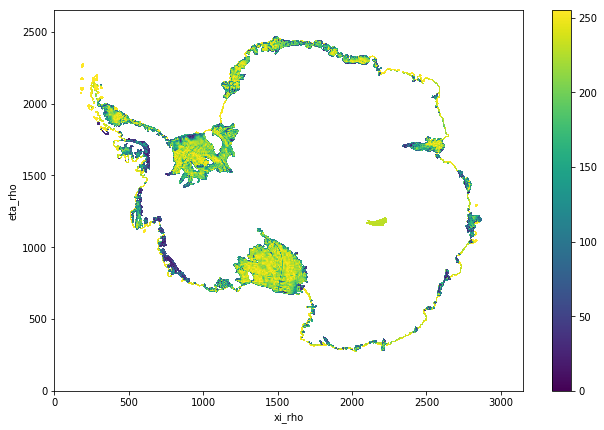

In [95]:
plt.close()
nemo_da[:,:,0].plot(size=7)
plt.show()

In [129]:
shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 
shelves2 = np.load(shelves_masks_path,allow_pickle=True).item()

shelf_mask = np.zeros_like(grd2.mask_rho)[::2,::2]
for key,values in log_progress(shelves2.items(),every=2):
        shelf_mask[values['mask'][::2,::2]==1]=1
#front_map = xr.DataArray(front_map,dims=('eta_rho','xi_rho')).where(front_map==1)

## Digitize colormap
### get rid of gray and black and white

<IPython.core.display.Javascript object>


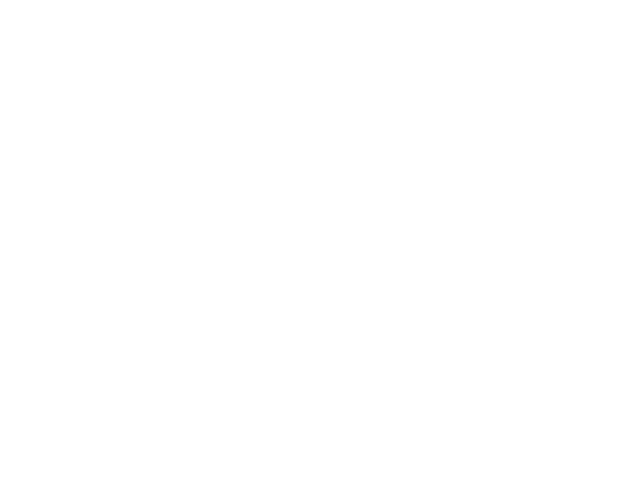

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

nemo = nemo_da.values[::10,::10].astype('uint8')
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

<IPython.core.display.Javascript object>


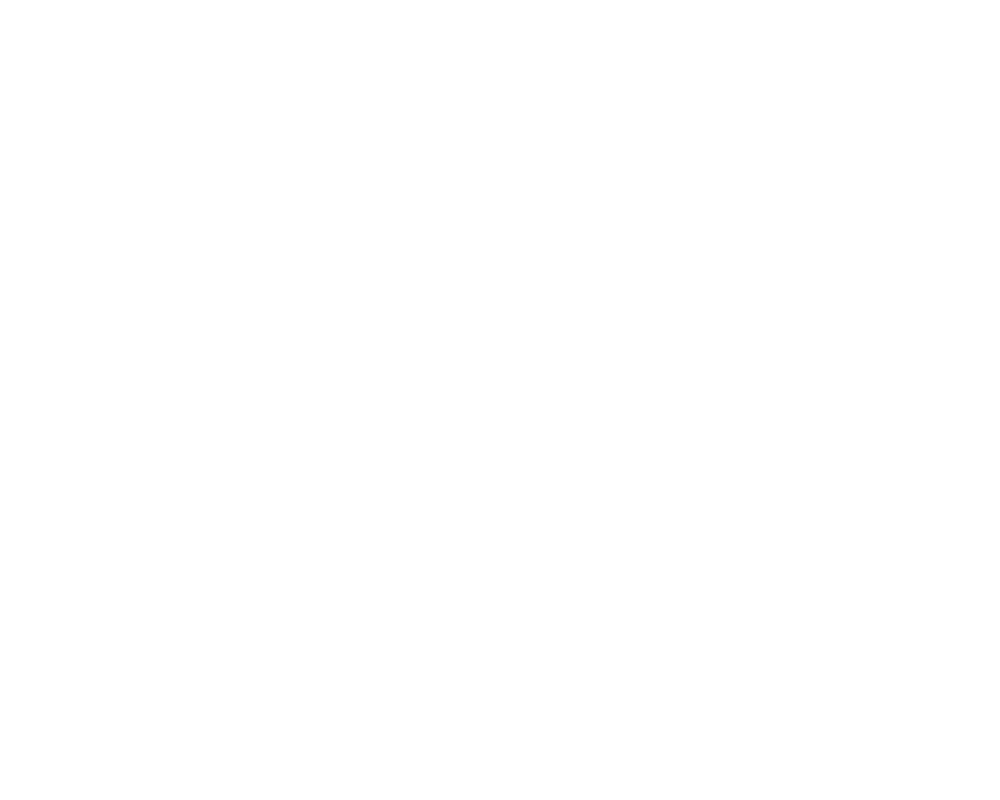

In [7]:
%matplotlib notebook
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_nemo)
plt.close()
fig = plt.figure(figsize=(10,8))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

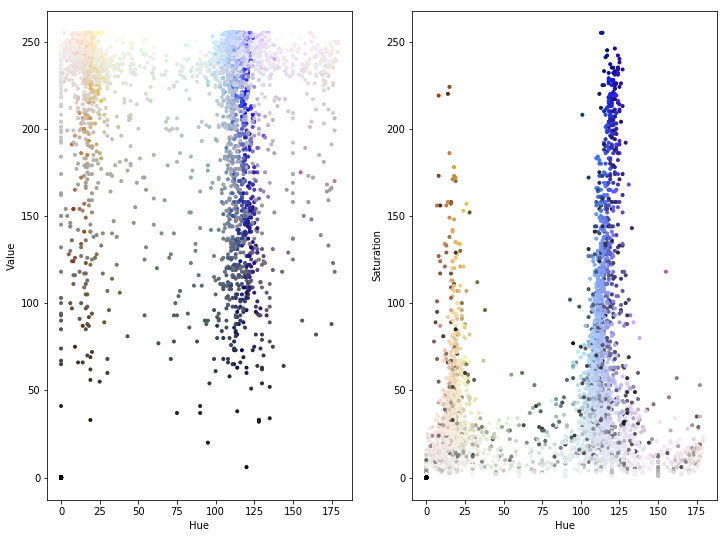

In [8]:
%matplotlib inline
plt.close()
fig = plt.figure(figsize=(12,9))
axis = fig.add_subplot(1, 2, 1)
axis.scatter(h.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Value")
axis = fig.add_subplot(1, 2, 2)
axis.scatter(h.flatten(), s.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
#axis.set_xlim(0,10)
plt.show()

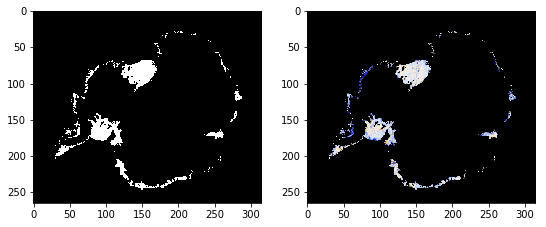

In [9]:
from matplotlib.colors import hsv_to_rgb,rgb_to_hsv
%matplotlib inline
light_gray = (0,0,0)
dark_gray = (1,1,255)

hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = ~cv2.inRange(hsv_nemo, light_gray, dark_gray)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(9,6))
ax1,ax2 = axes.flatten()
ax1.imshow(mask, cmap="gray")
ax2.imshow(result)
plt.show()

### interpolate the gray lines

<IPython.core.display.Javascript object>


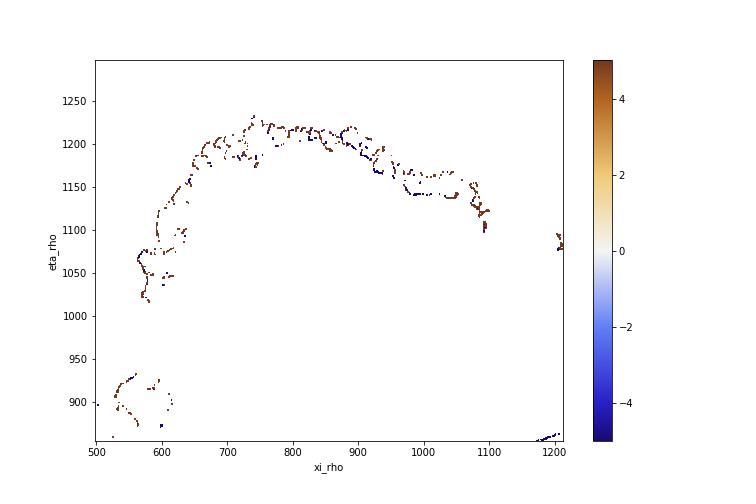

In [49]:
gray_mask = ((recon_da==-5) | (recon_da==5))
plt.close()
recon_da.where(gray_mask).plot(cmap=cmn,size=7)
plt.show()

In [50]:
from tools.NDinterp import NDinterp
test = recon_da.copy()
test.values[gray_mask]=np.nan
test.values = NDinterp(test.values)

<IPython.core.display.Javascript object>


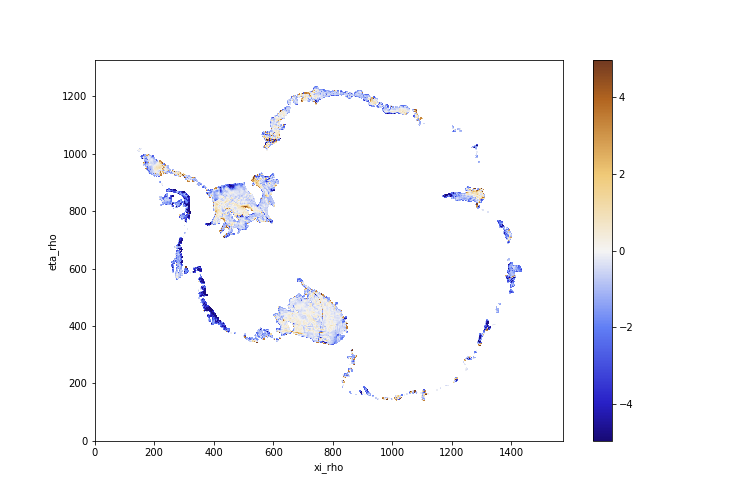

In [53]:
plt.close()
test.where(shelf_mask).plot(cmap=cmn,size=7)
plt.show()

# Ben's estimates

In [188]:
from scipy.ndimage import gaussian_filter
ben_path = os.path.join(data_dir,'external','ben','Richter_20190801.mat')
ben_raw = sio.loadmat(ben_path)
ben_raw = dict((k, np.flipud(np.rot90(np.array(ben_raw[k])))) for k in ['m','draft','uv_la','uv_lo'])
ben_raw['m'] = gaussian_filter(ben_raw['m'].copy(),sigma=3)*-1

In [160]:
waom_grd_path = os.path.join(proj_dir,'data','preprocessing','processed','waom10_grd.nc')
waom_grd = xr.open_dataset(waom_grd_path)

In [162]:
dA = (waom_grd.pn*waom_grd.pm)**-1

wla = waom_grd.lat_rho.values
wlo = waom_grd.lon_rho.values

bla = ben_raw['uv_la']
blo = ben_raw['uv_lo']

dA_on_ben=griddata((wla.flatten(),wlo.flatten()),dA.values.flatten(),(bla,blo),method='nearest')

In [163]:
draft = waom_grd.zice.where((waom_grd.mask_rho ==1) & (waom_grd.zice<0))

draft_on_ben = griddata((wla.flatten(),wlo.flatten()),draft.values.flatten(),(bla,blo),method='nearest')

In [164]:
shift = 0.85-ben.m.mean()

In [190]:
ii = ~np.isnan(ben_raw['m'])
ben = xr.Dataset({'m':(('y','x'),ben_raw['m'][ii]+shift),
            'draft':(('y','x'),ben_raw['draft']),
            'draft_bm':(('y','x'),draft_on_ben),
            'mask':(('y','x'),~np.isnan(ben_raw['m'])),
            'lat':(('y','x'),ben_raw['uv_la']),
            'lon':(('y','x'),ben_raw['uv_lo']),
             'dA':(('y','x'),dA_on_ben*0.01)})

ValueError: applied function returned data with unexpected number of dimensions: 1 vs 0, for dimensions ()

<IPython.core.display.Javascript object>


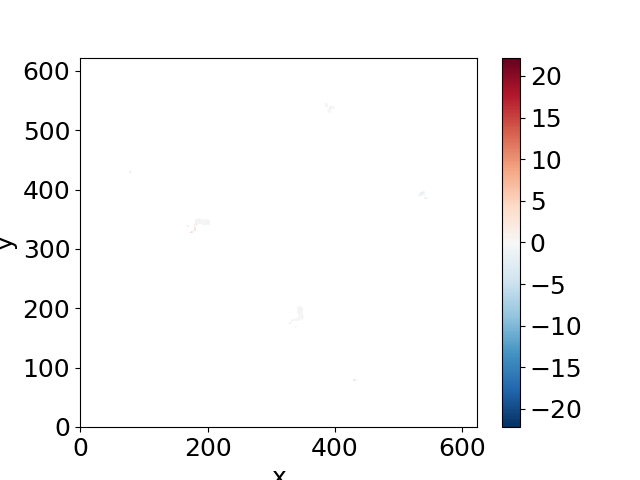

In [158]:
%matplotlib notebook
ben.m.where(ben.mask)[::10,::10].plot()

In [115]:
dA = ben.dA.where(ben.mask)
weights = dA/dA.sum()

rhoi = 917
ismr = (ben.m_shift*weights).sum()
bmb = (ben.m_shift*dA*rhoi*10**-12).sum()

print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
print('Area average melt rate in m/yr: ',ismr.values)
print('Basal mass loss in Gt/a: ',bmb.values)

Area of all ice shelves in 10^3 km^2:  1173.4939044783096
Area average melt rate in m/yr:  0.8515737632280989
Basal mass loss in Gt/a:  916.3733408717118


In [47]:
from dask.distributed import Client
C = Client()
C

Client Scheduler: tcp://127.0.0.1:53512 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [116]:
ben['m_shift'] = ben.m_shift.chunk({'x':1000,'y':1000})

In [145]:
mask = ben.mask
bins = np.arange(0,2800,100)
depths = ben.draft
ismr2bmb = dA*rhoi*(10**-12)

<IPython.core.display.Javascript object>


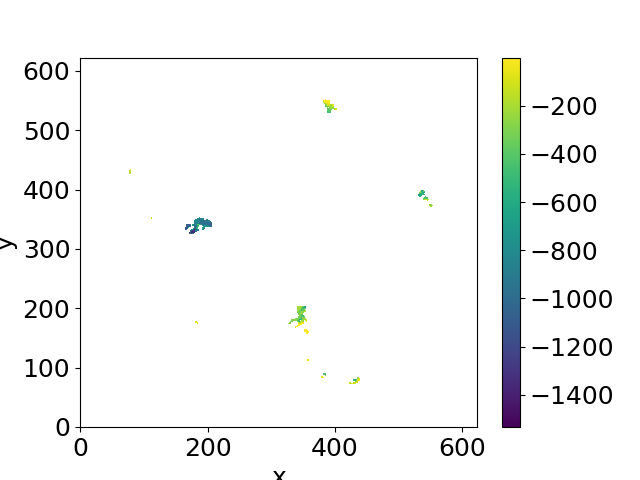

In [146]:
plt.close()
depths.where(ben.mask)[::10,::10].plot()
plt.show()

In [130]:
ismr = (ben.m_shift*weights).groupby_bins(depths,bins).sum().to_series()
A = dA.groupby_bins(depths,bins).sum().to_series()*10**-9
bmb =  ((ben.m_shift*ismr2bmb).groupby_bins(depths,bins).sum()).to_series()

ValueError: `group` must have a name

<IPython.core.display.Javascript object>


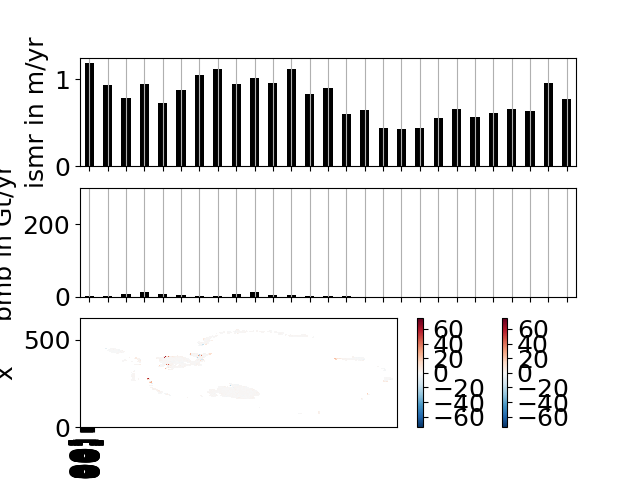

In [123]:
plt.rcParams.update({'font.size': 18})
plt.close()
fig,axes = plt.subplots(3)
ax1,ax2,ax3 = axes.flatten()
ismr.plot.bar(ax=ax1,color='k')
bmb.plot.bar(ax=ax2,color='k')
A.plot.bar(ax=ax3,color='k')
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('bmb in Gt/yr')
ax3.set_ylabel('A in 10^3 km^2')
for ax in [ax1,ax2]:
    #ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.xaxis.grid(True)
ax3.xaxis.grid(True)
ax3.set_xlabel('depth bins in m')
#ax1.set_ylim(0,5.2)
ax2.set_ylim(0,300)
ax3.set_ylim(0,440)
plt.savefig(os.path.join(fig_dir,'ben_depth_bins.png'),transparent=True,bbox_inches = "tight")
plt.show()

In [ ]:
mask_sector = np.load(os.path.join(int_dir,'sector2.npy'))

sec_depth = {}

for sec_key,sec_mask in log_progress(mask_sector.items(),name='sector'):
    sec_depth[sec_key]={}
    
    for depth_key,depth_mask in mask_depth.items():
        
        mask = sec_mask & depth_mask

        dA = (1/(grd.pm*grd.pn)).where(mask)
        weights = dA/dA.sum()

        ismr2bmb = dA*rhoi*(10**-12)

        sec_depth[sec_key]["A "+depth_key] = dA.sum().values*10**-9
        sec_depth[sec_key]["ismr "+depth_key] = (m.where(mask)*weights).sum().values*s2a
        sec_depth[sec_key]["bmb "+depth_key] = (m.where(mask)*ismr2bmb).sum().values*s2a
        
df_melt = pd.DataFrame.from_dict(sec_depth, orient='index').T

In [290]:
def make_mask_front(grd,nb_cells):
    
    mask_rho = grd.mask_rho.values
    mask_land = np.zeros_like(mask_rho)
    mask_land[mask_rho == 0] = 1
    mask_zice = np.zeros_like(mask_land)
    mask_zice[grd.zice.values*mask_rho != 0] = 1

    mask_front = np.zeros_like(grd.mask_rho.values)

    for j in grd.eta_rho.values:
        for i in grd. xi_rho.values:
            if mask_zice[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(mask_rho,1))

                if np.any(mask_zice[j_min:j_max,i_min:i_max] + mask_land[j_min:j_max,i_min:i_max]== 0):
                        mask_front[j,i] = 1
                        
    grd['mask_front'] = (('eta_rho','xi_rho'),mask_front)
    
    return grd

In [291]:
waom_grd = make_mask_front(waom_grd,2)

In [292]:
import pandas as pd
def make_mass_loss_table(m,grd,
                         google_sheet_url='https://docs.google.com/spreadsheets/d/1BpI6iRB569kF7TxdiFT3ColNVH9zwHgNwq49Dat7Ok4/edit?usp=sharing',
                        idx_start=0,idx_end=69,include_no_front=True):
    
    csv_export_url = google_sheet_url.replace('edit?', 'export?gid=0&format=csv&')
    IS = pd.read_csv(csv_export_url)

    rhoi = 916

    mask_ice = (grd.mask_rho==1) & (grd.zice<0)

    for idx,row in log_progress(IS.iloc[idx_start:idx_end].iterrows(),name='Ice shelf',every=1): 

        if row.lon_min<row.lon_max:
            mask_coord = (grd.lon_rho>row.lon_min) & (grd.lon_rho<=row.lon_max) & (grd.lat_rho>row.lat_min) & (grd.lat_rho<=row.lat_max)
        else:
            mask_coord = ((grd.lon_rho>row.lon_min) | (grd.lon_rho<=row.lon_max)) & (grd.lat_rho>row.lat_min) & (grd.lat_rho<=row.lat_max)

        mask_shelf = mask_ice & mask_coord
        
        dA = (1/(grd.pm*grd.pn)).where(mask_shelf)
        weights = dA/dA.sum()
        
        dA_l = dA.where(m > 0.0)
        weights_l = dA_l/dA_l.sum()
        
        dA_g = dA.where(m < 0.0)
        weights_g = dA_g/dA_g.sum()
        
        ismr2bmb = dA*rhoi*(10**-12)

        IS.at[idx,"A"] = float(dA.sum().values)*10**-9
        IS.at[idx,"ismr"] = float((m.where(mask_shelf)*weights).sum().values)
        IS.at[idx,"ismr_l"] = float((m.where(mask_shelf & (m > 0.0))*weights_l).sum().values)
        IS.at[idx,"ismr_g"] = float((m.where(mask_shelf & (m < 0.0))*weights_g).sum().values)
        IS.at[idx,"bmb"] = float((m.where(mask_shelf)*ismr2bmb).sum().values)
        IS.at[idx,"bml"] = float((m.where(mask_shelf & (m > 0.0))*ismr2bmb).sum().values)
        IS.at[idx,"bmg"] = float((m.where(mask_shelf & (m < 0.0))*ismr2bmb).sum().values)
        
        if include_no_front:
            
            dA = dA.where(grd.mask_front == 0)
            weights = dA/dA.sum()
            
            dA_l = dA.where(m > 0.0)
            weights_l = dA_l/dA_l.sum()

            dA_g = dA.where(m < 0.0)
            weights_g = dA_g/dA_g.sum()
            
            ismr2bmb = dA*rhoi*(10**-12)
            
            IS.at[idx,"A_nf"] = float(dA.sum().values)*10**-9
            IS.at[idx,"ismr_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0))*weights).sum().values)
            IS.at[idx,"ismr_nf_l"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m > 0.0))*weights_l).sum().values)
            IS.at[idx,"ismr_nf_g"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m < 0.0))*weights_g).sum().values)
            IS.at[idx,"bmb_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0))*ismr2bmb).sum().values)
            IS.at[idx,"bml_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m > 0.0))*ismr2bmb).sum().values)
            IS.at[idx,"bmg_nf"] = float((m.where(mask_shelf & (grd.mask_front == 0) & (m < 0.0))*ismr2bmb).sum().values)

        
    return IS

In [293]:
IS = make_mass_loss_table(wb,waom_grd,include_no_front=True)
IS

,Names,lat_min,lon_min,lat_max,lon_max,A,ismr,ismr_l,ismr_g,bmb,bml,bmg,A_nf,ismr_nf,ismr_nf_l,ismr_nf_g,bmb_nf,bml_nf,bmg_nf
0,Larsen G,-74.70,-62.55,-74.36,-61.35,0.44,-2.72,3.09,-4.27,-1.10,0.26,-1.36,0.38,-3.70,2.10,-4.25,-1.28,0.06,-1.34
1,Larsen F,-74.44,-61.96,-73.85,-60.55,0.96,2.21,3.29,-5.88,1.94,2.55,-0.61,0.73,1.90,3.32,-5.88,1.27,1.88,-0.61
2,Larsen E,-73.72,-62.61,-73.11,-60.05,1.33,2.20,3.78,-1.04,2.68,3.10,-0.42,1.12,1.75,3.55,-1.04,1.79,2.21,-0.42
3,Larsen D,-73.00,-62.70,-69.40,-59.30,14.43,2.14,3.01,-2.42,28.23,33.38,-5.16,12.95,2.19,3.15,-2.50,25.94,31.02,-5.07
4,Larsen C,-69.30,-65.50,-66.10,-60.00,55.66,0.61,1.24,-0.44,30.99,39.46,-8.46,54.07,0.61,1.24,-0.42,30.35,38.22,-7.86
5,Larsen B,-66.10,-62.75,-65.00,-59.00,4.45,1.17,2.15,-1.13,4.77,6.15,-1.38,3.19,1.38,2.39,-1.08,4.01,4.93,-0.92
6,Wordie,-69.49,-68.24,-68.75,-66.86,0.96,3.67,3.67,0.00,3.23,3.23,0.00,0.53,3.96,3.96,0.00,1.94,1.94,0.00
7,Wilkins,-71.50,-75.00,-69.70,-69.50,15.12,3.56,3.56,0.00,49.30,49.30,0.00,13.00,3.28,3.28,0.00,39.06,39.06,0.00
8,Bach,-72.38,-75.37,-71.50,-70.30,5.33,3.78,3.92,-2.83,18.47,18.74,-0.27,4.57,2.85,2.93,-1.78,11.93,12.05,-0.12
9,George VI 1,-73.80,-74.50,-72.60,-67.00,12.91,3.58,3.59,-0.22,42.37,42.37,-0.00,12.15,3.58,3.58,-0.22,39.83,39.83,-0.00


In [294]:
def merge_patches(df,name1,name2,name):
    p1 = df.loc[df['Names'] == name1]
    p2 = df.loc[df['Names'] == name2]
    
    m = {'Names':name,'A':np.nan,'bmb':np.nan,'bml':np.nan,'bmg':np.nan,'ismr':np.nan,'ismr_l':np.nan,'ismr_g':np.nan,
         'A_nf':np.nan,'bmb_nf':np.nan,'bml_nf':np.nan,'bmg_nf':np.nan,'ismr_nf':np.nan,'ismr_nf_l':np.nan,'ismr_nf_g':np.nan,}
    for key in ['A','bmb','bml','bmg','A_nf','bmb_nf','bml_nf','bmg_nf']:
        m[key] = p1[key].values + p2[key].values
    for key in ['ismr','ismr_l','ismr_g','ismr_nf','ismr_nf_l','ismr_nf_g']:    
        m[key] = ((p1[key]*p1.A_nf).values + (p2[key]*p2.A_nf).values) / m['A_nf']
    
    df = pd.concat([df,pd.DataFrame(m)],ignore_index=True)

    return df

In [295]:
IS_merged = merge_patches(IS,'George VI 1','George VI 2','George VI')
IS_merged = merge_patches(IS_merged,'Ronne','Filchner','Ronne-Filchner')
IS_merged = merge_patches(IS_merged,'Moscow University','Totten','Moscow Uni + Totten')
IS_merged = merge_patches(IS_merged,'Brunt/Stancomb','Riiser-Larsen','Brunt + Riiser-Larsen')
IS_merged = merge_patches(IS_merged,'Fimbul','Jelbart','Fimbul + Jelbart')
IS_merged = merge_patches(IS_merged,'Ross West','Ross East','Ross')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [296]:
IS_out = IS_merged[['Names','A','bmb','ismr',
                    'A_nf','bmb_nf','ismr_nf',
                    'bml','bmg','ismr_l','ismr_g',
                    'bml_nf','bmg_nf','ismr_nf_l','ismr_nf_g',
                    'lon_min','lat_min','lon_max','lat_max']] 

pd.options.display.float_format = '{:,.2f}'.format

IS_out

,Names,A,bmb,ismr,A_nf,bmb_nf,ismr_nf,bml,bmg,ismr_l,ismr_g,bml_nf,bmg_nf,ismr_nf_l,ismr_nf_g,lon_min,lat_min,lon_max,lat_max
0,Larsen G,0.44,-1.10,-2.72,0.38,-1.28,-3.70,0.26,-1.36,3.09,-4.27,0.06,-1.34,2.10,-4.25,-62.55,-74.70,-61.35,-74.36
1,Larsen F,0.96,1.94,2.21,0.73,1.27,1.90,2.55,-0.61,3.29,-5.88,1.88,-0.61,3.32,-5.88,-61.96,-74.44,-60.55,-73.85
2,Larsen E,1.33,2.68,2.20,1.12,1.79,1.75,3.10,-0.42,3.78,-1.04,2.21,-0.42,3.55,-1.04,-62.61,-73.72,-60.05,-73.11
3,Larsen D,14.43,28.23,2.14,12.95,25.94,2.19,33.38,-5.16,3.01,-2.42,31.02,-5.07,3.15,-2.50,-62.70,-73.00,-59.30,-69.40
4,Larsen C,55.66,30.99,0.61,54.07,30.35,0.61,39.46,-8.46,1.24,-0.44,38.22,-7.86,1.24,-0.42,-65.50,-69.30,-60.00,-66.10
5,Larsen B,4.45,4.77,1.17,3.19,4.01,1.38,6.15,-1.38,2.15,-1.13,4.93,-0.92,2.39,-1.08,-62.75,-66.10,-59.00,-65.00
6,Wordie,0.96,3.23,3.67,0.53,1.94,3.96,3.23,0.00,3.67,0.00,1.94,0.00,3.96,0.00,-68.24,-69.49,-66.86,-68.75
7,Wilkins,15.12,49.30,3.56,13.00,39.06,3.28,49.30,0.00,3.56,0.00,39.06,0.00,3.28,0.00,-75.00,-71.50,-69.50,-69.70
8,Bach,5.33,18.47,3.78,4.57,11.93,2.85,18.74,-0.27,3.92,-2.83,12.05,-0.12,2.93,-1.78,-75.37,-72.38,-70.30,-71.50
9,George VI 1,12.91,42.37,3.58,12.15,39.83,3.58,42.37,-0.00,3.59,-0.22,39.83,-0.00,3.58,-0.22,-74.50,-73.80,-67.00,-72.60


In [297]:
IS_out.to_csv(mass_loss_table_out_path)